In [ ]:
# !pip install opencv-python

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import cv2


In [2]:
def show_tensor_image(tensor):  # 텐서 순서를 (C, H, W)에서 (H, W, C)로 변경하고 numpy array로 변환
    image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
def val_plot(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training and Test Loss')

    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(test_accuracies, label='Test Accuracy')  # , color='orange'
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].set_title('Training and Test Accuracy')

    plt.tight_layout()
    plt.show()

In [4]:
def cuda_message():
    if torch.cuda.is_available():
        print("CUDA(GPU)를 사용합니다.")
    else:
        print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda_message()

CUDA(GPU)를 사용합니다.


In [6]:
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self, model_num=18, num_classes=2):
        super(myResNet, self).__init__()

        if model_num == 18:
            self.resnet = models.resnet18(weights=None)
        elif model_num == 34:
            self.resnet = models.resnet34(weights=None)
        elif model_num == 50:
            self.resnet = models.resnet50(weights=None)
        elif model_num == 101:
            self.resnet = models.resnet101(weights=None)
        elif model_num == 152:
            self.resnet = models.resnet152(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [7]:
# myVGG 클래스 정의
class myVGG(nn.Module):
    def __init__(self, model_kind="16", num_classes=2):
        super(myVGG, self).__init__()

        if model_kind == "11":
            self.vgg = models.vgg11(weights=None)
        elif model_kind == "11_bn":
            self.vgg = models.vgg11_bn(weights=None)
        elif model_kind == "13":
            self.vgg = models.vgg13(weights=None)
        elif model_kind == "13_bn":
            self.vgg = models.vgg13_bn(weights=None)
        elif model_kind == "16":
            self.vgg = models.vgg16(weights=None)
        elif model_kind == "16_bn":
            self.vgg = models.vgg16_bn(weights=None)
        elif model_kind == "19":
            self.vgg = models.vgg19(weights=None)
        elif model_kind == "19_bn":
            self.vgg = models.vgg19_bn(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vgg.classifier[6].in_features  # classifier["6"] -> 6, vgg에서 정해진 수?
        self.vgg.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.vgg(x)

In [8]:
# myLeNet 클래스 정의
class myLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(myLeNet, self).__init__()
        self.lenet = models.googlenet(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.lenet.fc.in_features
        self.lenet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.lenet(x)

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()  # 어차피 train에선 test와 달리 loss.backward() 해야하기 때문에 loss 따로 객체화
        loss.backward()
        optimizer.step()
    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)  # output.argmax(dim=1, keepdim=True)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()  # pred.eq(target.view_as(pred)).sum().item()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [10]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # .view_as(): View this tensor as the same size as other. self.view_as(other) is equivalent to self.view(other.size())
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [11]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()
    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [12]:
# import shutil
# shutil.rmtree('C:/Users/bgmbg/Downloads/face_age/.ipynb_checkpoints')

In [13]:
trans_origin = transforms.Compose(
    [
        # transforms.CenterCrop((500, 500)),  # norm 계산 여부
        transforms.ToTensor(),
    ]
)

# 아래 수정/출력 요망

# full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
# test_dataset_origin = ImageFolder('IMAGE/Covid19-dataset/test', transform=trans_origin)
# test_loader_origin = torch.utils.data.DataLoader(test_dataset_origin, batch_size=64, shuffle=False)

# original_images, _ = next(iter(test_loader_origin))
# transform_images, _ = next(iter(test_loader))

# fig, axes = plt.subplots(3, 3)
# fig.set_size_inches(4, 6)

# for idx in range(3):
#     axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 0].set_axis_off()
#     axes[idx, 0].set_title('Original (200,200)')
#     axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 1].set_axis_off()
#     axes[idx, 1].set_title('Resized (100,100)')
#     axes[idx, 2].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 2].set_axis_off()
#     axes[idx, 2].set_title('Resized (50,50)')
# fig.tight_layout()
# plt.show()

In [14]:
# 데이터 증강! (500sets 이하 애들만 2배 뻥튀기)

# 입력 이미지 디렉토리
input_dir = "C:/Users/bgmbg/Downloads/face_age"

# 출력 이미지 디렉토리
output_dir = "C:/Users/bgmbg/Downloads/face_age"
os.makedirs(output_dir, exist_ok=True)

aug_needed = ["/10-12", "/13-15", "/30-34", "/40-44", "/45-49", "/55-59", "/60-64", "/65-69"]

# 각 디렉토리를 돌면서 이미지 증강 및 저장
for category_dir in aug_needed:
    category_path = input_dir + '' + category_dir
    print(input_dir)
    print(category_path)
    if os.path.isdir(category_path):
        category_output_dir = output_dir + '' + category_dir
        print(category_output_dir)
        os.makedirs(category_output_dir, exist_ok=True)
        
        # 이미지를 순회하면서 증강 및 저장
        for filename in os.listdir(category_path):
            print(filename)
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = category_path + '/' + filename
                print(img_path)
                # 이미지 불러오기
                img_plus = cv2.imread(img_path)
                img_plus = cv2.cvtColor(img_plus, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽어옴.  # , cv2.COLOR_BGR2RGB
                
                # 이미지 증강
                img_flip_lr = cv2.flip(img_plus,1)
                
                # 증강된 이미지 저장
                cv2.imwrite(category_output_dir + '/' + f"{filename}_flip_lr.jpg", cv2.cvtColor(img_flip_lr, cv2.COLOR_RGB2BGR))

C:/Users/bgmbg/Downloads/face_age
C:/Users/bgmbg/Downloads/face_age/10-12
C:/Users/bgmbg/Downloads/face_age/10-12
1016.png
C:/Users/bgmbg/Downloads/face_age/10-12/1016.png
1016.png_flip_lr.jpg
C:/Users/bgmbg/Downloads/face_age/10-12/1016.png_flip_lr.jpg
1022.png
C:/Users/bgmbg/Downloads/face_age/10-12/1022.png
1022.png_flip_lr.jpg
C:/Users/bgmbg/Downloads/face_age/10-12/1022.png_flip_lr.jpg
1023.png
C:/Users/bgmbg/Downloads/face_age/10-12/1023.png
1023.png_flip_lr.jpg
C:/Users/bgmbg/Downloads/face_age/10-12/1023.png_flip_lr.jpg
1064.png
C:/Users/bgmbg/Downloads/face_age/10-12/1064.png
1064.png_flip_lr.jpg
C:/Users/bgmbg/Downloads/face_age/10-12/1064.png_flip_lr.jpg
1069.png
C:/Users/bgmbg/Downloads/face_age/10-12/1069.png
1069.png_flip_lr.jpg
C:/Users/bgmbg/Downloads/face_age/10-12/1069.png_flip_lr.jpg
1076.png
C:/Users/bgmbg/Downloads/face_age/10-12/1076.png
1076.png_flip_lr.jpg
C:/Users/bgmbg/Downloads/face_age/10-12/1076.png_flip_lr.jpg
1106.png
C:/Users/bgmbg/Downloads/face_age/10-

In [15]:
torch.manual_seed(42)

# 데이터 전처리
transform = transforms.Compose([
    # transforms.Resize((50, 50)),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.6360717, 0.4874842, 0.41885874),
                         (0.21104145, 0.18984404, 0.18253866))  # 이미지를 -1에서 1로 정규화
])
# 데이터셋 로드
full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
print(full_dataset)
count = Counter(full_dataset.targets)
print(count)

# 데이터를 훈련셋과 테스트셋으로 랜덤으로 분할
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

cnt = []
for i in range(train_size):  #
    cnt.append(train_dataset[i][1])
print(Counter(cnt))
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 15526
    Root location: ./face_age
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.6360717, 0.4874842, 0.41885874), std=(0.21104145, 0.18984404, 0.18253866))
           )
Counter({7: 1440, 13: 1197, 11: 1113, 0: 1112, 2: 1065, 14: 1017, 15: 951, 1: 927, 10: 912, 6: 856, 17: 794, 4: 759, 5: 661, 3: 554, 8: 554, 9: 554, 12: 539, 16: 521})
Counter({7: 1126, 13: 952, 0: 917, 11: 904, 2: 866, 14: 804, 1: 766, 15: 752, 10: 732, 6: 677, 17: 628, 4: 616, 5: 526, 8: 441, 9: 435, 16: 432, 3: 425, 12: 421})


In [16]:
# 인덱스, 눈금 수정 요망
# age_sorted = ['1', '2-3', '4-6', '7-9', '10-12',
#               '13-15', '16-19', '20-24', '25-29', '30-34',
#               '35-39', '40-44', '45-49', '50-54', '55-59',
#               '60-64', '65-69', '70']
# age_dict = {'1': 0, '10-12': 1, '13-15': 2, '16-19': 3, '2-3': 4,
#             '20-24': 5, '25-29': 6, '30-34': 7, '35-39': 8, '4-6': 9,
#             '40-44': 10, '45-49': 11, '50-54': 12, '55-59': 13, '60-64': 14,
#             '65-69': 15, '7-9': 16, '70': 17}

# age_list = list(count.keys())
# frequencies = list(count.values())

# plt.bar(age_list, frequencies)
# plt.xlabel('age')
# plt.show()

In [17]:
### 1. resnet18
### 1-1. resnet18 / SGD
### 1-2. resnet18 / RMSprop
### 1-3. resnet18 / AdamW
### 2. vgg13
### 3. googlenet

### 1-1-1. resnet18 / SGD(lr=0.010, mo=0.9)

In [18]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.9)

In [19]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [20]:
for epoch in range(1, 51):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4461, Accuracy: 50.00%
Test loss: 2.2876, Accuracy: 24.31%
Epoch 2, Training loss: 1.9026, Accuracy: 50.00%
Test loss: 2.2159, Accuracy: 27.95%
Epoch 3, Training loss: 1.6723, Accuracy: 75.00%
Test loss: 2.1143, Accuracy: 30.68%
Epoch 4, Training loss: 1.3234, Accuracy: 50.00%
Test loss: 1.9632, Accuracy: 38.57%
Epoch 5, Training loss: 1.0671, Accuracy: 0.00%
Test loss: 1.8069, Accuracy: 44.62%
Epoch 6, Training loss: 0.8864, Accuracy: 25.00%
Test loss: 1.9473, Accuracy: 45.88%
Epoch 7, Training loss: 0.6538, Accuracy: 50.00%
Test loss: 1.9090, Accuracy: 51.48%
Epoch 8, Training loss: 0.4242, Accuracy: 100.00%
Test loss: 1.6982, Accuracy: 55.02%
Epoch 9, Training loss: 0.2878, Accuracy: 25.00%
Test loss: 2.0298, Accuracy: 54.15%
Epoch 10, Training loss: 0.3975, Accuracy: 50.00%
Test loss: 1.8654, Accuracy: 53.90%
Epoch 11, Training loss: 0.3247, Accuracy: 50.00%
Test loss: 2.1029, Accuracy: 52.00%
Epoch 12, Training loss: 0.2441, Accuracy: 50.00%
Test loss: 2.

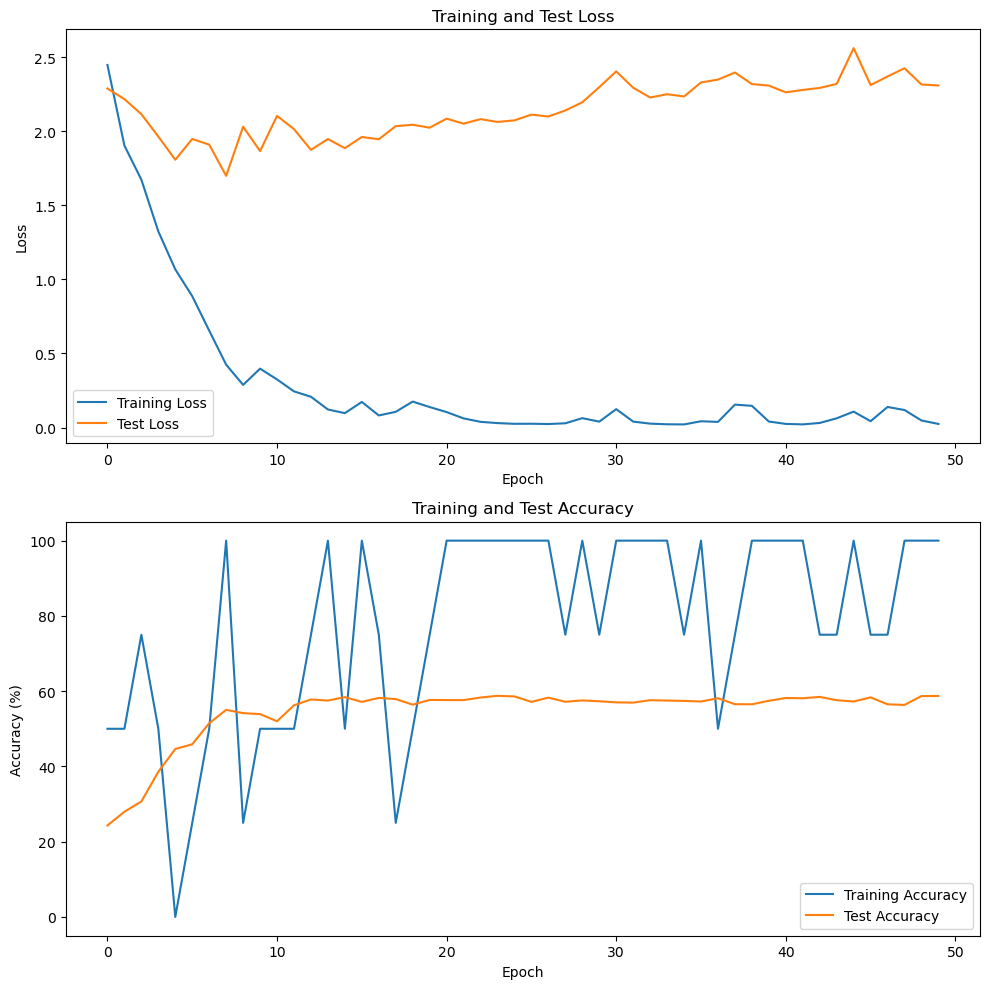

In [21]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-5. resnet18 / RMSprop(lr=0.005, mo=0.5)

In [24]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.5)

In [25]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [26]:
for epoch in range(1, 51):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.0142, Accuracy: 50.00%
Test loss: 2.6838, Accuracy: 17.58%
Epoch 2, Training loss: 2.3012, Accuracy: 0.00%
Test loss: 2.7751, Accuracy: 13.23%
Epoch 3, Training loss: 2.0648, Accuracy: 0.00%
Test loss: 3.1105, Accuracy: 16.19%
Epoch 4, Training loss: 1.8902, Accuracy: 0.00%
Test loss: 2.0186, Accuracy: 27.01%
Epoch 6, Training loss: 1.6779, Accuracy: 0.00%
Test loss: 3.5907, Accuracy: 16.77%
Epoch 7, Training loss: 1.5513, Accuracy: 25.00%
Test loss: 2.3223, Accuracy: 30.20%
Epoch 8, Training loss: 1.4195, Accuracy: 50.00%
Test loss: 4.6282, Accuracy: 15.33%
Epoch 9, Training loss: 1.2580, Accuracy: 25.00%
Test loss: 2.3807, Accuracy: 31.26%
Epoch 10, Training loss: 1.1067, Accuracy: 50.00%
Test loss: 2.2784, Accuracy: 35.22%
Epoch 11, Training loss: 0.8908, Accuracy: 75.00%
Test loss: 2.9043, Accuracy: 32.84%
Epoch 12, Training loss: 0.6778, Accuracy: 75.00%
Test loss: 1.6826, Accuracy: 50.29%
Epoch 13, Training loss: 0.4861, Accuracy: 75.00%
Test loss: 2.751

KeyboardInterrupt: 

In [ ]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

## Final Model - 증강 / 200->100 resized /  / epoch = 25

In [32]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.9)

In [33]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [34]:
for epoch in range(1, 26):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4403, Accuracy: 50.00%
Test loss: 2.4113, Accuracy: 20.44%
Epoch 2, Training loss: 1.9465, Accuracy: 50.00%
Test loss: 2.1243, Accuracy: 27.50%
Epoch 3, Training loss: 1.6317, Accuracy: 25.00%
Test loss: 1.9187, Accuracy: 34.13%
Epoch 4, Training loss: 1.3459, Accuracy: 0.00%
Test loss: 2.1434, Accuracy: 31.87%
Epoch 5, Training loss: 1.1669, Accuracy: 50.00%
Test loss: 1.8812, Accuracy: 43.30%
Epoch 6, Training loss: 0.8145, Accuracy: 25.00%
Test loss: 1.6616, Accuracy: 50.32%
Epoch 7, Training loss: 0.6836, Accuracy: 25.00%
Test loss: 1.8453, Accuracy: 48.78%
Epoch 8, Training loss: 0.4224, Accuracy: 75.00%
Test loss: 1.7651, Accuracy: 55.51%
Epoch 9, Training loss: 0.3934, Accuracy: 75.00%
Test loss: 1.8163, Accuracy: 54.15%
Epoch 10, Training loss: 0.3366, Accuracy: 50.00%
Test loss: 1.8977, Accuracy: 55.44%
Epoch 11, Training loss: 0.3883, Accuracy: 25.00%
Test loss: 2.1442, Accuracy: 54.60%
Epoch 12, Training loss: 0.3056, Accuracy: 50.00%
Test loss: 1.8

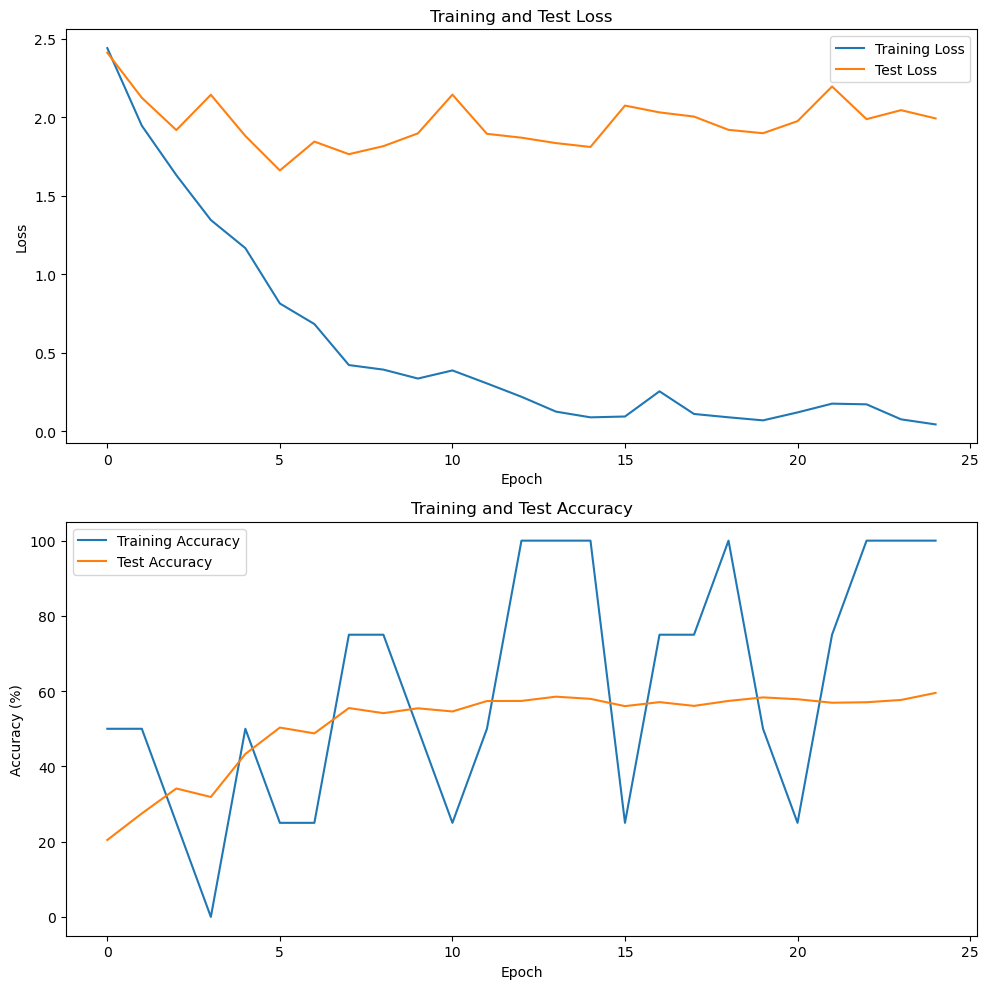

In [35]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

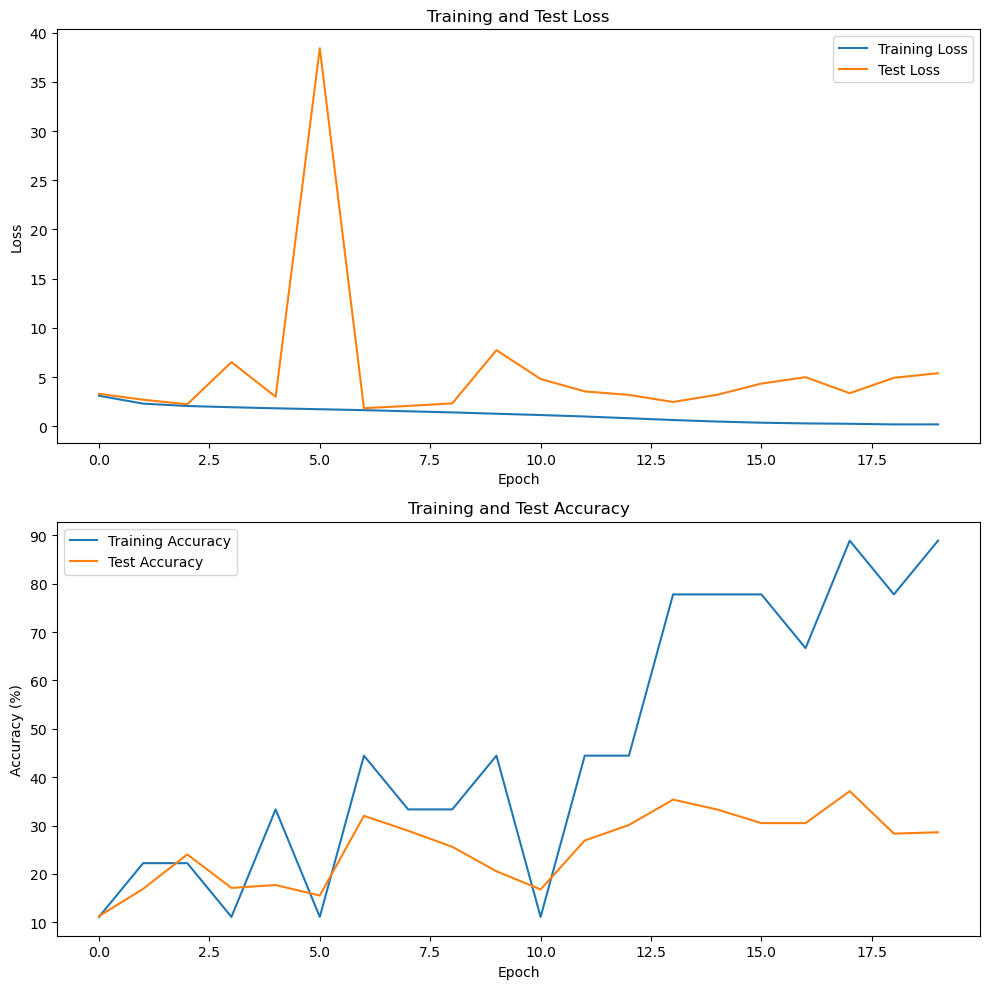

In [133]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

In [134]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

In [135]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [136]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.9276, Accuracy: 22.22%
Test loss: 2.8002, Accuracy: 18.33%
Epoch 2, Training loss: 2.3262, Accuracy: 0.00%
Test loss: 2.2670, Accuracy: 19.44%
Epoch 3, Training loss: 2.1532, Accuracy: 11.11%
Test loss: 2.3100, Accuracy: 19.95%
Epoch 4, Training loss: 1.9940, Accuracy: 22.22%
Test loss: 2.0714, Accuracy: 25.44%
Epoch 5, Training loss: 1.8781, Accuracy: 33.33%
Test loss: 1.8597, Accuracy: 30.23%
Epoch 6, Training loss: 1.7714, Accuracy: 0.00%
Test loss: 1.8747, Accuracy: 33.54%
Epoch 7, Training loss: 1.6622, Accuracy: 55.56%
Test loss: 1.8238, Accuracy: 32.52%
Epoch 8, Training loss: 1.5583, Accuracy: 44.44%
Test loss: 1.7494, Accuracy: 34.61%
Epoch 9, Training loss: 1.4423, Accuracy: 66.67%
Test loss: 3.2667, Accuracy: 33.66%
Epoch 10, Training loss: 1.3253, Accuracy: 44.44%
Test loss: 1.7537, Accuracy: 35.64%
Epoch 11, Training loss: 1.1743, Accuracy: 77.78%
Test loss: 1.8992, Accuracy: 35.99%
Epoch 12, Training loss: 1.0109, Accuracy: 55.56%
Test loss: 1.91

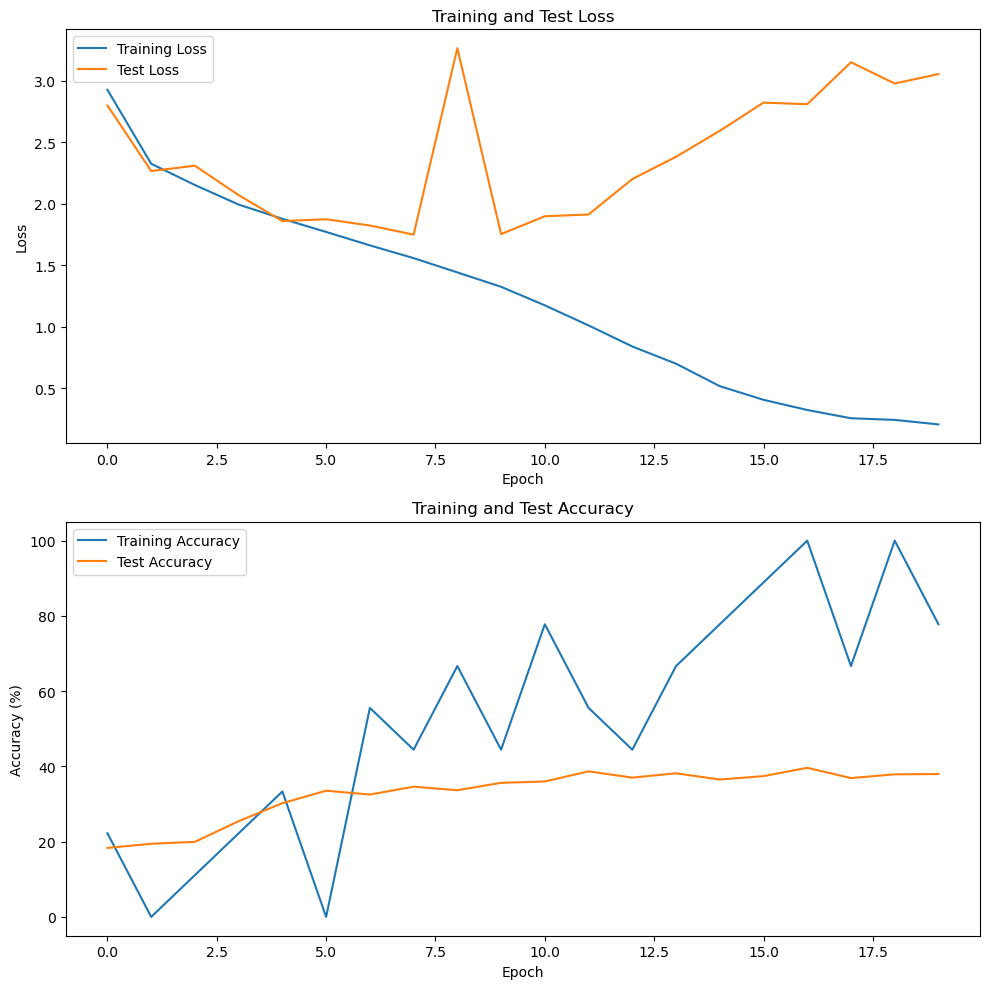

In [137]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### resized 별 비교

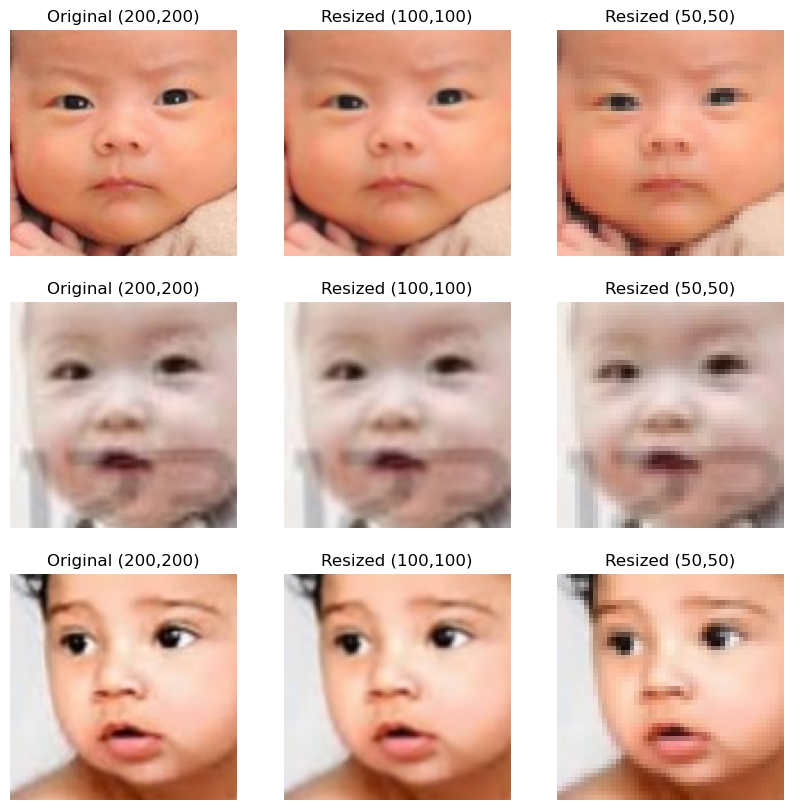

In [31]:
trans_origin = transforms.Compose(
    [
        # transforms.CenterCrop((500, 500)),  # norm 계산 여부
        transforms.ToTensor(),
    ]
)

trans_50 = transforms.Compose(
    [
        transforms.Resize((50, 50)),
        transforms.ToTensor(),
    ]
)

trans_100 = transforms.Compose(
    [
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
    ]
)

full_dataset_origin = datasets.ImageFolder(root='./face_age', transform=trans_origin)
full_dataset_50 = datasets.ImageFolder(root='./face_age', transform=trans_50)
full_dataset_100 = datasets.ImageFolder(root='./face_age', transform=trans_100)

# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader_origin = DataLoader(full_dataset_origin, batch_size=64, shuffle=False)
train_loader_50 = DataLoader(full_dataset_50, batch_size=64, shuffle=False)
train_loader_100 = DataLoader(full_dataset_100, batch_size=64, shuffle=False)

original_images, _ = next(iter(train_loader_origin))
transform_images1, _ = next(iter(train_loader_100))
transform_images2, _ = next(iter(train_loader_50))

fig, axes = plt.subplots(3, 3)
fig.set_size_inches(10, 10)

for idx in range(3):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0), cmap='gray')
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original (200,200)')
    axes[idx, 1].imshow(transform_images1[idx].permute(1, 2, 0), cmap='gray')
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('Resized (100,100)')
    axes[idx, 2].imshow(transform_images2[idx].permute(1, 2, 0), cmap='gray')
    axes[idx, 2].set_axis_off()
    axes[idx, 2].set_title('Resized (50,50)')
# fig.tight_layout()
plt.show()

In [36]:
# 예측
# 새로운 데이터셋 로드 및 전처리

from PIL import Image
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 이미지 불러오기
image_path = "C:/Users/bgmbg/Downloads/26.png"  # 단일 이미지의 경로
image = Image.open(image_path)

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize((0.6360717, 0.4874842, 0.41885874), (0.21104145, 0.18984404, 0.18253866))
])
input_image = transform(image).unsqueeze(0)  # 배치 차원 추가

# 모델 평가 모드로 설정
model.eval()

# 예측 실행
with torch.no_grad():
    input_image = input_image.to(device)
    output = model(input_image)
    pred = output.argmax(dim=1, keepdim=True)
    # _, predicted = torch.max(output, 1)
    # i, predicted = torch.topk(output, 3)

# 소프트맥스 적용
probabilities = F.softmax(output[0], dim=0)

# 확률값과 해당 클래스 인덱스를 튜플로 묶어서 리스트로 저장
prob_list = [(prob.item(), idx) for idx, prob in enumerate(probabilities)]

# 확률값을 기준으로 내림차순 정렬
prob_list.sort(reverse=True)

# 상위 3개 확률값과 해당 클래스 인덱스 출력
top5_probabilities = prob_list[:5]

# 클래스 라벨과 클래스 이름
age_list = ['1', '10-12', '13-15', '16-19', '2-3', '20-24', '25-29', '30-34', '35-39', '4-6', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '7-9', '70']

print("상위 5개 확률값:")
for prob, idx in top5_probabilities:
    print(f"{age_list[idx]}일 확률: {prob:.4f}")

상위 5개 확률값:
13-15일 확률: 0.6015
30-34일 확률: 0.1552
16-19일 확률: 0.1219
10-12일 확률: 0.0975
20-24일 확률: 0.0113
